# Οπλισμένο Σκυρόδεμα ΙΙ: Αποτελέσματα SAP2000 - Πίνακες

In [1]:
#!pip install streng

In [2]:
from streng.codes.eurocodes.ec8.cls.seismic_action.spectra import SpectraEc8
from streng.codes.eurocodes.ec2.raw.ch5.geometric_data import effective_width
from streng.ppp.sections.geometry.tee import TeeSectionGeometry
from streng.ppp.sections.geometry.rectangular import RectangularSectionGeometry
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
import pandas as pd

## Δεδομένα

### Μεταβλητές φοιτητή

κ, λ τα τελευταία δύο ψηφία του ΑΕΜ, πχ για ΑΕΜ 1234 ή CIV91234 θα είναι κ=3, λ=4

In [3]:
κ = 3
λ = 4

### Διαστάσεις φορέα

$L = 19.5 - 0.1 * κ$

$H = 6.20 - 0.1 * λ$

$α = L / 4$

$L_1 = L / 2$

In [4]:
L = 19.5 - 0.1 * κ
H = 6.20 - 0.1 * λ
α = L / 4
L1 = L / 2

print(f'L = {L:.2f}m')
print(f'H = {H:.2f}m')
print(f'α = {α:.3f}m')
print(f'L1 = {L1:.3f}m')

L = 19.20m
H = 5.80m
α = 4.800m
L1 = 9.600m


### Διαστάσεις διατομών

Σε όλα τα δομικά στοιχεία να θεωρηθεί ότι η ονομαστική τιμή της επικάλυψης των οπλισμών είναι 25mm

In [5]:
cnom = 0.003 # m

#### Δοκοί

$b_w = 0.40\text{m}$

$h_f = 0.20\text{m}$

$h = 1.15\text{m}$ για $λ\le4$

$h = 1.05\text{m}$ για $λ\ge 5$

Το συνεργαζόμενο πλάτος $b_{eff}$ να υπολογιστεί σύμφωνα με τις σχέσεις του EC2

In [6]:
# Διαστάσεις δοκών
bw = 0.40
hf = 0.20
if λ <= 4:
    h = 1.15
else:
    h = 1.05

print(f'bw = {bw:.2f}m')
print(f'h = {h:.2f}m')
print(f'hf = {hf:.2f}m')
print(f'h - hf = {h - hf:.2f}m')

bw = 0.40m
h = 1.15m
hf = 0.20m
h - hf = 0.95m


#### Υπολογισμός συνεργαζόμενου πλάτους

Η θεωρητική απόσταση ανάμεσα σε δύο σημεία μηδενισμού των ροπών είναι:
$l_0 = 0.7\cdot L_1 = 7.00\text{m}$ για μεσαίο άνοιγμα (ροπή και στις δύο στηρίξεις)

Η καθαρή απόσταση ανάμεσα σε δύο δοκούς στην εγκάρσια διεύθυνση είναι:

$L_{n,εγκ1} = L_{n,εγκ2} = α - 2 * \dfrac{b_w}{2} = 4.60\text{m}$

$b_1 = b_2 = \dfrac{L_{n,εγκ1}}{2} = 2.30\text{m}$

$b = b_w + b_1 + b_2 = 5.00\text{m}$

$b_{eff,i}=0.2\cdot b_i +0.1\cdot l_0 \le 0.2\cdot l_0$

$b_{eff,1} = b_{eff,2} = 0.2 * 2.30 + 0.1 * 7.0 = 1.16\text{m} < 0.2 \cdot l_0 = 1.4\text{m}$

In [7]:
l0 = effective_width.l0(l2 = L1, zero_moments_case=2)
ln_eg1 = ln_eg2 = α - bw
b1 = b2 = ln_eg1 / 2.0
_b = bw + b1 + b2
beff1 = beff2 = effective_width.beffi(b1, l0)
beff = beff2 = effective_width.beff(bw, beff1, beff2, _b)

print(f'l0 = {l0:.3f}m')
print(f'Ln,εγκ1 = Ln,εγκ2 = {ln_eg1:.3f}m')
print(f'b1 = b2 = {b1:.3f}m')
print(f'b = {_b:.3f}m')
print(f'beff1 = beff2 = {beff1:.3f}m')
print(f'beff = {beff:.3f}m')

l0 = 6.720m
Ln,εγκ1 = Ln,εγκ2 = 4.400m
b1 = b2 = 2.200m
b = 4.800m
beff1 = beff2 = 1.112m
beff = 2.624m


#### Στύλοι 
(χρησιμοποιώ δείκτη **c**(olumn) ώστε να μη γίνεται σύγχυση με τις διαστάσεις των δοκών)

$b_c = 0.40\text{m}$

$h_c = 1.10\text{m}$ για $λ\le4$

$h_c = 1.00\text{m}$ για $λ\ge 5$

In [8]:
# Διαστάσεις στύλων
bc = 0.40
if λ <= 4:
    hc = 1.05
else:
    hc = 0.95
print(f'bc = {bc:.2f}m')    
print(f'hc = {hc:.2f}m')

bc = 0.40m
hc = 1.05m


## Φορτία

Πάχος επιστρώσεων: $h_{επιστ} = 0.05 - 0.002 \cdot λ$ (m)

Ύψος τοιχοπληρώσεων: $h_{hτοιχ} = 3.00 + 0.05 \cdot κ$ (m)

Ειδικά βάρη:

$γ_{σκυρ} = 25.0$ (kN/m3)

$γ_{επιστ} = 23.0 - 0.2 \cdot λ$ (kN/m3)

$γ_{τοιχ} = 3.6$ (kN/m2)

In [9]:
hεπιστ = 0.05 - 0.002 * λ
hτοιχ = 3 + 0.05 * κ

γσκυρ = 25.0 # kN/m3
γεπιστ = 23.0 - 0.2 * λ
γτοιχ = 3.6

print(f'hεπιστ = {hεπιστ:.3f}m')
print(f'hτοιχ = {hτοιχ:.3f}m')  
print(f'γσκυρ = {γσκυρ:.2f}kN/m3')  
print(f'γεπιστ = {γεπιστ:.2f}kN/m3')  
print(f'γτοιχ = {γτοιχ:.2f}kN/m2')  

hεπιστ = 0.042m
hτοιχ = 3.150m
γσκυρ = 25.00kN/m3
γεπιστ = 22.20kN/m3
γτοιχ = 3.60kN/m2


### Φορτία πλακών

#### Μόνιμα φορτία πλακών

In [10]:
Gπλ_ιβ = γσκυρ * hf
Gπλ_επιστ = γεπιστ * hεπιστ
Gπλ_ολ = Gπλ_ιβ + Gπλ_επιστ

print(f'Gπλ_ιβ = {Gπλ_ιβ:.2f}kN/m2')
print(f'Gπλ_επιστ = {Gπλ_επιστ:.2f}kN/m2')
print(f'Gπλ_ολ = {Gπλ_ολ:.2f}kN/m2')

Gπλ_ιβ = 5.00kN/m2
Gπλ_επιστ = 0.93kN/m2
Gπλ_ολ = 5.93kN/m2


#### Ωφέλιμα φορτία πλακών

In [11]:
Qπλ = 5.0 # kN/m2

### Φορτία δοκών

#### Μόνιμα φορτία

In [12]:
GΔ_πλ = Gπλ_ολ * (α/2 + α/2)
GΔ_τοιχ = γτοιχ * hτοιχ
GΔ_ιβ = γσκυρ * bw * (h - hf)
GΔ_ολ = GΔ_πλ + GΔ_τοιχ + GΔ_ιβ

print(f'GΔ_πλ = {GΔ_πλ:.2f}kN/m')
print(f'GΔ_τοιχ = {GΔ_τοιχ:.2f}kN/m')
print(f'GΔ_ιβ = {GΔ_ιβ:.2f}kN/m')
print(f'GΔ_ολ = {GΔ_ολ:.2f}kN/m')

GΔ_πλ = 28.48kN/m
GΔ_τοιχ = 11.34kN/m
GΔ_ιβ = 9.50kN/m
GΔ_ολ = 49.32kN/m


#### Ωφέλιμα φορτία

In [13]:
QΔ = Qπλ * (α/2 + α/2)

print(f'QΔ = {QΔ:.2f}kN/m')

QΔ = 24.00kN/m


### Υπολογισμός μάζας

In [14]:
g = 9.81
M = (GΔ_ολ + 0.3 * QΔ) * L  / g

## Προσομοίωση στο OpenSees - Υπολογισμός ιδιοπεριόδου

In [15]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

E = 30000000
U = 0.2
G = E / (2.0*(1.0+U))

tbeam = TeeSectionGeometry(bw = bw, h = h, beff=beff, hf = hf)
A_tbeam = tbeam.area
Iz_tbeam = tbeam.moment_of_inertia_xx * 0.5
Avy_tbeam = tbeam.shear_area_2 * 0.5

rect_col = RectangularSectionGeometry(b=bc, h=hc)
A_col = rect_col.area
Iz_col = rect_col.moment_of_inertia_xx * 0.5
Avy_col = rect_col.shear_area_2 * 0.5

ops.node(1, 0., 0.)
ops.node(2, 0., H)
ops.node(3, L1, 0.)
ops.node(4, L1, H)
ops.node(5, 2 * L1, 0.)
ops.node(6, 2 * L1, H)

ops.fix(1, 1, 1, 1)
ops.fix(3, 1, 1, 1)
ops.fix(5, 1, 1, 1)

ops.geomTransf('Linear', 1)

ops.mass(int(2), M, 1.0e-10, 1.0e-10)

for node in [4, 6]:
    ops.equalDOF(2, node, 1)
    
ops.element('ElasticTimoshenkoBeam', 1, 1, 2, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 2, 3, 4, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 3, 5, 6, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 4, 2, 4, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 5, 4, 6, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')

elem_type = {1: 'col', 2: 'col', 3: 'col', 4: 'beam', 5: 'beam'}

numEigen = 1
eigenValues = ops.eigen('-fullGenLapack', numEigen)

_periods = []
for i in range(0, numEigen):
    lamb = eigenValues[i]
    period = 2 * np.pi / np.sqrt(lamb)
    _periods.append(period)
    print(f'Period {i+1} = {period:.4f}s')

Period 1 = 0.2360s


## Σεισμικά φορτία

- Κατηγορία πλαστιμότητας: Μέση
- Κατηγορία σπουδαιότητας: II (Συνήθη κτίρια)
- Συντελεστής συμπεριφοράς: $q = 3.9$

- Κατηγορία εδάφους:
  - Για $λ\le 3$: Βαθιές εναποθέσεις πυκνής άμμου
  - Για $4\leλ\le7$ Πολύ σκληρή άργιλος πάχους αρκετών δεκάδων μέτρων
  - Για $λ\ge8$: Βράχος


- Ζώνη σεισμικής επικινδυνότητας:
  - Για $κ\le 3$: Ζώνη I
  - Για $4\leκ\le7$: Ζώνη II
  - Για $κ\ge8$: Ζώνη III

In [16]:
if λ <=3:
    agR = 0.16
elif λ>=8:
    agR=0.36
else:
    agR=0.24
    
if κ <=3:
    ground_type = 'C'
elif κ>=8:
    ground_type = 'A'
else:
    ground_type = 'B'


q = 3.9

γI=1.0
λ_ec8 = 1.0

T = 0.27 # sec

specEC8 = SpectraEc8(αgR=agR,
                     γI=γI,
                     ground_type = ground_type,
                     spectrum_type = 
                     1,
                     η=1.0,
                     q=q,
                     β=0.2)

print(f'TB = {specEC8.TB:.2f}sec')
print(f'TC = {specEC8.TC:.2f}sec')
print(f'TD = {specEC8.TD:.2f}sec')
print()
Sd_T = specEC8.Sd(T) * g
V = M * Sd_T * λ_ec8
Ex = V

print(f'Sd_T = {Sd_T:.2f}')
print(f'M = {M:.2f}t')
print(f'V = {V:.2f}kN')
print(f'Ex = {Ex:.2f}kN')



TB = 0.20sec
TC = 0.60sec
TD = 2.00sec

Sd_T = 1.74
M = 110.61t
V = 191.98kN
Ex = 191.98kN


## Επίλυση με το OpenSees

In [17]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

E = 30000000
U = 0.2
G = E / (2.0*(1.0+U))

tbeam = TeeSectionGeometry(bw = bw, h = h, beff=beff, hf = hf)
A_tbeam = tbeam.area
Iz_tbeam = tbeam.moment_of_inertia_xx * 0.5
Avy_tbeam = tbeam.shear_area_2 * 0.5

rect_col = RectangularSectionGeometry(b=bc, h=hc)
A_col = rect_col.area
Iz_col = rect_col.moment_of_inertia_xx * 0.5
Avy_col = rect_col.shear_area_2 * 0.5

ops.node(1, 0., 0.)
ops.node(2, 0., H)
ops.node(3, L1, 0.)
ops.node(4, L1, H)
ops.node(5, 2 * L1, 0.)
ops.node(6, 2 * L1, H)

ops.fix(1, 1, 1, 1)
ops.fix(3, 1, 1, 1)
ops.fix(5, 1, 1, 1)

ops.geomTransf('Linear', 1)

ops.mass(int(2), M, 1.0e-10, 1.0e-10)

for node in [4, 6]:
    ops.equalDOF(2, node, 1)
    
ops.element('ElasticTimoshenkoBeam', 1, 1, 2, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 2, 3, 4, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 3, 5, 6, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 4, 2, 4, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 5, 4, 6, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')

elem_type = {1: 'col', 2: 'col', 3: 'col', 4: 'beam', 5: 'beam'}

numEigen = 1
eigenValues = ops.eigen('-fullGenLapack', numEigen)

_periods = []
for i in range(0, numEigen):
    lamb = eigenValues[i]
    period = 2 * np.pi / np.sqrt(lamb)
    _periods.append(period)
    print(f'Period {i+1} = {period:.4f}s')

results_ele = []

# Ex Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.load(2, Ex, 0., 0.)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['Ex', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# G-1 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -GΔ_ολ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['G-1', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# G-2 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -GΔ_ολ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['G-2', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# Q-1 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -QΔ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['Q-1', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# Q-2 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -QΔ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['Q-2', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

Period 1 = 0.2360s


<Figure size 1440x432 with 0 Axes>

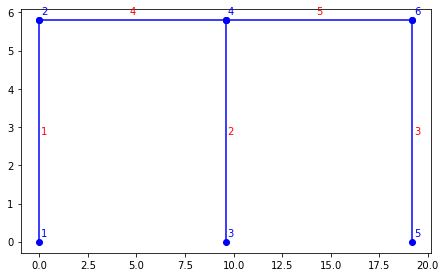

In [18]:
fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(left=.08, bottom=.08, right=.94, top=.94)
# ax1 = plt.subplot(111)

opsv.plot_model()

## Επεξεργασία αποτελεσμάτων

### Ανάγνωση εντατικών μεγεθών από το OpenSees

#### Σύμφωνα με τους τοπικούς άξονες του OpenSees

In [19]:
results_df = pd.DataFrame(data=results_ele,
                          columns =['load_case', 'elem_id', 'elem_type', 'Fxi_', 'Fyi_', 'Mi_', 'Fxj_', 'Fyj_', 'Mj_'])
# results_df.round(2)
results_df[results_df['load_case']=='G-1'].round(2)

,load_case,elem_id,elem_type,Fxi_,Fyi_,Mi_,Fxj_,Fyj_,Mj_
5,G-1,1,col,39.39,220.96,-63.04,-39.39,-220.96,-165.43
6,G-1,2,col,-41.16,271.20,85.34,41.16,-271.20,153.38
7,G-1,3,col,1.77,-18.73,6.26,-1.77,18.73,-16.53
8,G-1,4,beam,0.00,220.96,165.43,0.00,252.47,-316.68
9,G-1,5,beam,0.00,18.73,163.29,0.00,-18.73,16.53


#### Μετατροπή των τοπικών αξόνων σε M-V-N (σύμφωνα με τα αποτελέσματα του SAP)

In [20]:
def ops_to_mvn(row):
    if row['elem_type'] == 'col':
        Ni = - row['Fyi_']
        Nj = + row['Fyj_']
        Vi = - row['Fxi_']
        Vj = + row['Fxj_']
        Mi = + row['Mi_']
        Mj = - row['Mj_']
    else:
        Ni = - row['Fxi_']
        Nj = row['Fxj_']
        Vi = - row['Fyi_']
        Vj = + row['Fyj_']  
        Mi = - row['Mi_']
        Mj = + row['Mj_']
    return Ni, Nj, Vi, Vj, Mi, Mj


results_df['Ni'], results_df['Nj'], results_df['Vi'], results_df['Vj'], \
    results_df['Mi'], results_df['Mj'] = zip(*results_df.apply(ops_to_mvn, axis=1))

results_df.round(2)

,load_case,elem_id,elem_type,Fxi_,Fyi_,Mi_,Fxj_,Fyj_,Mj_,Ni,Nj,Vi,Vj,Mi,Mj
0,Ex,1,col,-59.34,-26.41,193.59,59.34,26.41,150.60,26.41,26.41,59.34,59.34,193.59,-150.60
1,Ex,2,col,-73.29,0.00,219.29,73.29,0.00,205.81,-0.00,0.00,73.29,73.29,219.29,-205.81
2,Ex,3,col,-59.34,26.41,193.59,59.34,-26.41,150.60,-26.41,-26.41,59.34,59.34,193.59,-150.60
3,Ex,4,beam,0.00,-26.41,-150.60,0.00,26.41,-102.91,-0.00,0.00,26.41,26.41,150.60,-102.91
4,Ex,5,beam,0.00,-26.41,-102.91,0.00,26.41,-150.60,-0.00,0.00,26.41,26.41,102.91,-150.60
5,G-1,1,col,39.39,220.96,-63.04,-39.39,-220.96,-165.43,-220.96,-220.96,-39.39,-39.39,-63.04,165.43
6,G-1,2,col,-41.16,271.20,85.34,41.16,-271.20,153.38,-271.20,-271.20,41.16,41.16,85.34,-153.38
7,G-1,3,col,1.77,-18.73,6.26,-1.77,18.73,-16.53,18.73,18.73,-1.77,-1.77,6.26,16.53
8,G-1,4,beam,0.00,220.96,165.43,0.00,252.47,-316.68,-0.00,0.00,-220.96,252.47,-165.43,-316.68
9,G-1,5,beam,0.00,18.73,163.29,0.00,-18.73,16.53,-0.00,0.00,-18.73,-18.73,-163.29,16.53


### Εντατικά μεγέθη για τα στοιχεία 1, 2, 4

In [21]:
# Στήλες: load_case, elem_id, location, N, M, V
# Γραμμές: Στοιχεία 1, 2, 4

load_cases = list(results_df['load_case'].unique())
elements = [1, 2, 4]
locations = ['i', 'j']


df_selected = pd.DataFrame(columns=['load_case', 'elem_id', 'location', 'N', 'V', 'M'])

for lc in load_cases:
    for element in elements:
        for loc in locations:
            _N = float(results_df.loc[(results_df['load_case']==lc) & (results_df['elem_id']==element)]['N'+loc])
            _V = float(results_df.loc[(results_df['load_case']==lc) & (results_df['elem_id']==element)]['V'+loc])
            _M = float(results_df.loc[(results_df['load_case']==lc) & (results_df['elem_id']==element)]['M'+loc])
#             print(lc, element, loc, _M)
            df_selected = df_selected.append({'load_case': lc,
                  'elem_id': element,
                  'location': loc,
                  'N': _N,
                  'V':_V,
                  'M':_M},
                  ignore_index=True)

df_selected.round(2)

# results_df.loc[(results_df['load_case']=='Ex') & (results_df['elem_id']==1)]['Mi'][0]

,load_case,elem_id,location,N,V,M
0,Ex,1,i,26.41,59.34,193.59
1,Ex,1,j,26.41,59.34,-150.60
2,Ex,2,i,-0.00,73.29,219.29
3,Ex,2,j,0.00,73.29,-205.81
4,Ex,4,i,-0.00,26.41,150.60
5,Ex,4,j,0.00,26.41,-102.91
6,G-1,1,i,-220.96,-39.39,-63.04
7,G-1,1,j,-220.96,-39.39,165.43
8,G-1,2,i,-271.20,41.16,85.34
9,G-1,2,j,-271.20,41.16,-153.38


## Συνδυασμοί δράσεων - Εναλλακτές φορτίσεις

In [22]:
# D-D, D-E, E-D
# G+0.3Q+Ex, G+0.3Q-Ex

combos = ['D-D', 'D-E', 'E-D', 'G+0.3Q+Ex', 'G+0.3Q-Ex']

dict_selected = {}
for lc in load_cases:
    dict_selected[lc] = df_selected[df_selected['load_case']==lc]

    
load_cases = list(results_df['load_case'].unique())
elements = [1, 2, 4]
locations = ['i', 'j']


df_combos = pd.DataFrame(columns=['combo', 'elem_id', 'location', 'N', 'V', 'M'])


for element in elements:
    for loc in locations:
        dict_mvn = {}
        for lc in load_cases:
            dict_mvn[lc] = tuple(df_selected.loc[(df_selected['load_case']==lc) &
                                (df_selected['elem_id']==element) &
                                (df_selected['location']==loc)][['N', 'V', 'M']].values[0])
            
        df_combos = df_combos.append({'combo': 'D-D',
              'elem_id': element,
              'location': loc,
              'N': 1.35 * (dict_mvn['G-1'][0] + dict_mvn['G-2'][0]) + 1.5 * (dict_mvn['Q-1'][0] + dict_mvn['Q-2'][0]) ,
              'V': 1.35 * (dict_mvn['G-1'][1] + dict_mvn['G-2'][1]) + 1.5 * (dict_mvn['Q-1'][1] + dict_mvn['Q-2'][1]),
              'M': 1.35 * (dict_mvn['G-1'][2] + dict_mvn['G-2'][2]) + 1.5 * (dict_mvn['Q-1'][2] + dict_mvn['Q-2'][2])},                  
              ignore_index=True)
 
        df_combos = df_combos.append({'combo': 'D-E',
              'elem_id': element,
              'location': loc,
              'N': 1.35 * dict_mvn['G-1'][0] + dict_mvn['G-2'][0] + 1.5 * dict_mvn['Q-1'][0] ,
              'V': 1.35 * dict_mvn['G-1'][1] + dict_mvn['G-2'][1] + 1.5 * dict_mvn['Q-1'][1] ,
              'M': 1.35 * dict_mvn['G-1'][2] + dict_mvn['G-2'][2] + 1.5 * dict_mvn['Q-1'][2]},                  
              ignore_index=True)

        df_combos = df_combos.append({'combo': 'E-D',
              'elem_id': element,
              'location': loc,
              'N': 1.35 * dict_mvn['G-2'][0] + dict_mvn['G-1'][0] + 1.5 * dict_mvn['Q-2'][0] ,
              'V': 1.35 * dict_mvn['G-2'][1] + dict_mvn['G-1'][1] + 1.5 * dict_mvn['Q-2'][1] ,
              'M': 1.35 * dict_mvn['G-2'][2] + dict_mvn['G-1'][2] + 1.5 * dict_mvn['Q-2'][2]},                  
              ignore_index=True)
        
        df_combos = df_combos.append({'combo': 'G+0.3Q+Ex',
              'elem_id': element,
              'location': loc,
              'N': dict_mvn['G-1'][0] + dict_mvn['G-2'][0] + 0.3 * (dict_mvn['Q-1'][0] + dict_mvn['Q-2'][0]) + dict_mvn['Ex'][0],
              'V': dict_mvn['G-1'][1] + dict_mvn['G-2'][1] + 0.3 * (dict_mvn['Q-1'][1] + dict_mvn['Q-2'][1]) + dict_mvn['Ex'][1],
              'M': dict_mvn['G-1'][2] + dict_mvn['G-2'][2] + 0.3 * (dict_mvn['Q-1'][2] + dict_mvn['Q-2'][2]) + dict_mvn['Ex'][2]},                  
              ignore_index=True)        

        df_combos = df_combos.append({'combo': 'G+0.3Q-Ex',
              'elem_id': element,
              'location': loc,
              'N': dict_mvn['G-1'][0] + dict_mvn['G-2'][0] + 0.3 * (dict_mvn['Q-1'][0] + dict_mvn['Q-2'][0]) - dict_mvn['Ex'][0],
              'V': dict_mvn['G-1'][1] + dict_mvn['G-2'][1] + 0.3 * (dict_mvn['Q-1'][1] + dict_mvn['Q-2'][1]) - dict_mvn['Ex'][1],
              'M': dict_mvn['G-1'][2] + dict_mvn['G-2'][2] + 0.3 * (dict_mvn['Q-1'][2] + dict_mvn['Q-2'][2]) - dict_mvn['Ex'][2]},                  
              ignore_index=True) 
        
df_combos.round(2)

,combo,elem_id,location,N,V,M
0,D-D,1,i,-420.63,-78.25,-144.14
1,D-E,1,i,-440.86,-80.16,-137.38
2,E-D,1,i,-182.00,-35.71,-76.07
3,G+0.3Q+Ex,1,i,-205.35,16.23,114.17
4,G+0.3Q-Ex,1,i,-258.16,-102.46,-273.01
5,D-D,1,j,-420.63,-78.25,309.71
6,D-E,1,j,-440.86,-80.16,327.56
7,E-D,1,j,-182.00,-35.71,131.05
8,G+0.3Q+Ex,1,j,-205.35,16.23,20.04
9,G+0.3Q-Ex,1,j,-258.16,-102.46,321.24


### Διάκριση σε σεισμικούς συνδυασμούς και μη

In [23]:
df_combos_grav = df_combos.where(df_combos['combo'].str.find('Ex')==-1).dropna()
df_combos_seismic = df_combos.where(df_combos['combo'].str.find('Ex')!=-1).dropna()

display(df_combos_grav)
display(df_combos_seismic)

,combo,elem_id,location,N,V,M
0,D-D,1,i,-420.632182,-7.825039e+01,-1.441444e+02
1,D-E,1,i,-440.862112,-8.016165e+01,-1.373793e+02
2,E-D,1,i,-181.997730,-3.570925e+01,-7.606550e+01
5,D-D,1,j,-420.632182,-7.825039e+01,3.097079e+02
6,D-E,1,j,-440.862112,-8.016165e+01,3.275582e+02
7,E-D,1,j,-181.997730,-3.570925e+01,1.310481e+02
10,D-D,2,i,-1128.193914,-9.592327e-14,-2.472689e-13
11,D-E,2,i,-835.298288,4.445240e+01,9.217120e+01
12,E-D,2,i,-835.298288,-4.445240e+01,-9.217120e+01
15,D-D,2,j,-1128.193914,-9.592327e-14,3.069545e-13


,combo,elem_id,location,N,V,M
3,G+0.3Q+Ex,1,i,-205.345937,16.229856,114.172303
4,G+0.3Q-Ex,1,i,-258.159320,-102.455945,-273.008689
8,G+0.3Q+Ex,1,j,-205.345937,16.229856,20.039140
9,G+0.3Q-Ex,1,j,-258.159320,-102.455945,321.235793
13,G+0.3Q+Ex,2,i,-621.592727,73.293073,219.287997
14,G+0.3Q-Ex,2,i,-621.592727,-73.293073,-219.287997
18,G+0.3Q+Ex,2,j,-621.592727,73.293073,-205.811827
19,G+0.3Q-Ex,2,j,-621.592727,-73.293073,205.811827
23,G+0.3Q+Ex,4,i,-0.000000,-205.345937,-20.039140
24,G+0.3Q-Ex,4,i,0.000000,-258.159320,-321.235793


## Περιβάλλουσες

### Περιβάλλουσα για συνδυασμούς χωρίς σεισμό

In [24]:
df_env_grav = pd.DataFrame(columns=['elem_id', 'location', 'min-max', 'N(exM)', 'exM', 'exV'])

for element in elements:
    for loc in locations:
        df_temp = df_combos_grav.loc[(df_combos_grav['elem_id']==element) & (df_combos_grav['location']==loc)]

        minM = df_temp['M'].min()
        minV = df_temp['V'].min()
        N_for_minM = float(df_temp.loc[df_temp['M']==minM]['N'])
        maxM = df_temp['M'].max()
        maxV = df_temp['V'].max()
        N_for_maxM = float(df_temp.loc[df_temp['M']==maxM]['N'])

        
        df_env_grav = df_env_grav.append({'elem_id': element,
              'location': loc,
              'min-max': 'min',                            
              'N(exM)': N_for_minM,
              'exM': minM,
              'exV': minV},                  
              ignore_index=True)

        df_env_grav = df_env_grav.append({'elem_id': element,
              'location': loc,
              'min-max': 'max',                            
              'N(exM)': N_for_maxM,
              'exM': maxM,
              'exV': maxV},                  
              ignore_index=True)

df_env_grav.set_index(['elem_id', 'location', 'min-max'], inplace=True)     
df_env_grav.round(2)

N(exM)     exM     exV
elem_id location min-max                        
1       i        min     -420.63 -144.14  -80.16
                 max     -182.00  -76.07  -35.71
        j        min     -182.00  131.05  -80.16
                 max     -440.86  327.56  -35.71
2       i        min     -835.30  -92.17  -44.45
                 max     -835.30   92.17   44.45
        j        min     -835.30 -165.65  -44.45
                 max     -835.30  165.65   44.45
4       i        min       -0.00 -327.56 -440.86
                 max       -0.00 -131.05 -182.00
        j        min        0.00 -998.34  291.43
                 max        0.00 -656.33  564.10

### Περιβάλλουσα για σεισμικούς συνδυασμούς

In [25]:
df_env_seismic = pd.DataFrame(columns=['elem_id', 'location', 'min-max', 'N(exM)', 'exM', 'exV'])

for element in elements:
    for loc in locations:
        df_temp = df_combos_seismic.loc[(df_combos_seismic['elem_id']==element) & (df_combos_seismic['location']==loc)]

        minM = df_temp['M'].min()
        minV = df_temp['V'].min()
        N_for_minM = float(df_temp.loc[df_temp['M']==minM]['N'])
        maxM = df_temp['M'].max()
        maxV = df_temp['V'].max()
        N_for_maxM = float(df_temp.loc[df_temp['M']==maxM]['N'])

        
        df_env_seismic = df_env_seismic.append({'elem_id': element,
              'location': loc,
              'min-max': 'min',                            
              'N(exM)': N_for_minM,
              'exM': minM,
              'exV': minV},                  
              ignore_index=True)

        df_env_seismic = df_env_seismic.append({'elem_id': element,
              'location': loc,
              'min-max': 'max',                            
              'N(exM)': N_for_maxM,
              'exM': maxM,
              'exV': maxV},                  
              ignore_index=True)

df_env_seismic.set_index(['elem_id', 'location', 'min-max'], inplace=True)        
df_env_seismic.round(2)

N(exM)     exM     exV
elem_id location min-max                        
1       i        min     -258.16 -273.01 -102.46
                 max     -205.35  114.17   16.23
        j        min     -205.35   20.04 -102.46
                 max     -258.16  321.24   16.23
2       i        min     -621.59 -219.29  -73.29
                 max     -621.59  219.29   73.29
        j        min     -621.59 -205.81  -73.29
                 max     -621.59  205.81   73.29
4       i        min        0.00 -321.24 -258.16
                 max       -0.00  -20.04 -205.35
        j        min        0.00 -652.95  284.39
                 max        0.00 -447.14  337.20